# Worksheet 1

In this worksheet we'll attempt to infer the period of a star with a very simple light curve. There's just a single large spot on one side of the star, so we're going to model it with a versy simple sine curve. Let's assume we know everything else about the sine curve (the amplitude, phase, and offset). Here is the function we're going to use to fit the dataset:

$
m(P) = 1 + 0.1 \sin\left(\frac{2\pi}{P} t\right)
$

where $m$ is the model, $P$ is the period, and $t$ is time.

In [1]:
%matplotlib inline

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

## 1. Import the modules we'll need

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Generate the dataset

In [5]:
# Make dataset folder
import os
if not os.path.exists("data"):
    os.mkdir("data")
    
# Input values
truths = {
    "period": 7.654,
    "amplitude": 0.1,
    "phase": 0.0,
    "offset": 1.0,
    "error": 0.04,
}

# Generate the light curve
time = np.arange(0, 27, 1. / 24. / 60.)
truths["flux"] = np.sin(2 * np.pi * time / truths["period"] + truths["phase"])
truths["flux"] *= truths["amplitude"]
truths["flux"] += truths["offset"]

# Add noise
np.random.seed(11)
err = np.ones_like(truths["flux"]) * truths["error"]
flux = np.array(truths["flux"])
flux += np.random.randn(len(time)) * err

# Save
X = np.hstack((time.reshape(-1, 1), 
               flux.reshape(-1, 1), 
               err.reshape(-1, 1)))

np.savetxt("data/worksheet1.txt", X)

## 2. Load the dataset
It's stored in the text file ``data/worksheet1.txt``. We'll load the time array ``time``, the flux array ``flux``, and the array of uncertainties ``err``:

In [6]:
time, flux, err = np.loadtxt("data/worksheet1.txt").T

## 3. Plot the dataset
Plot the dataset (flux versus time) to visualize what we're dealing with, and eyeball the value of the period from the plot.

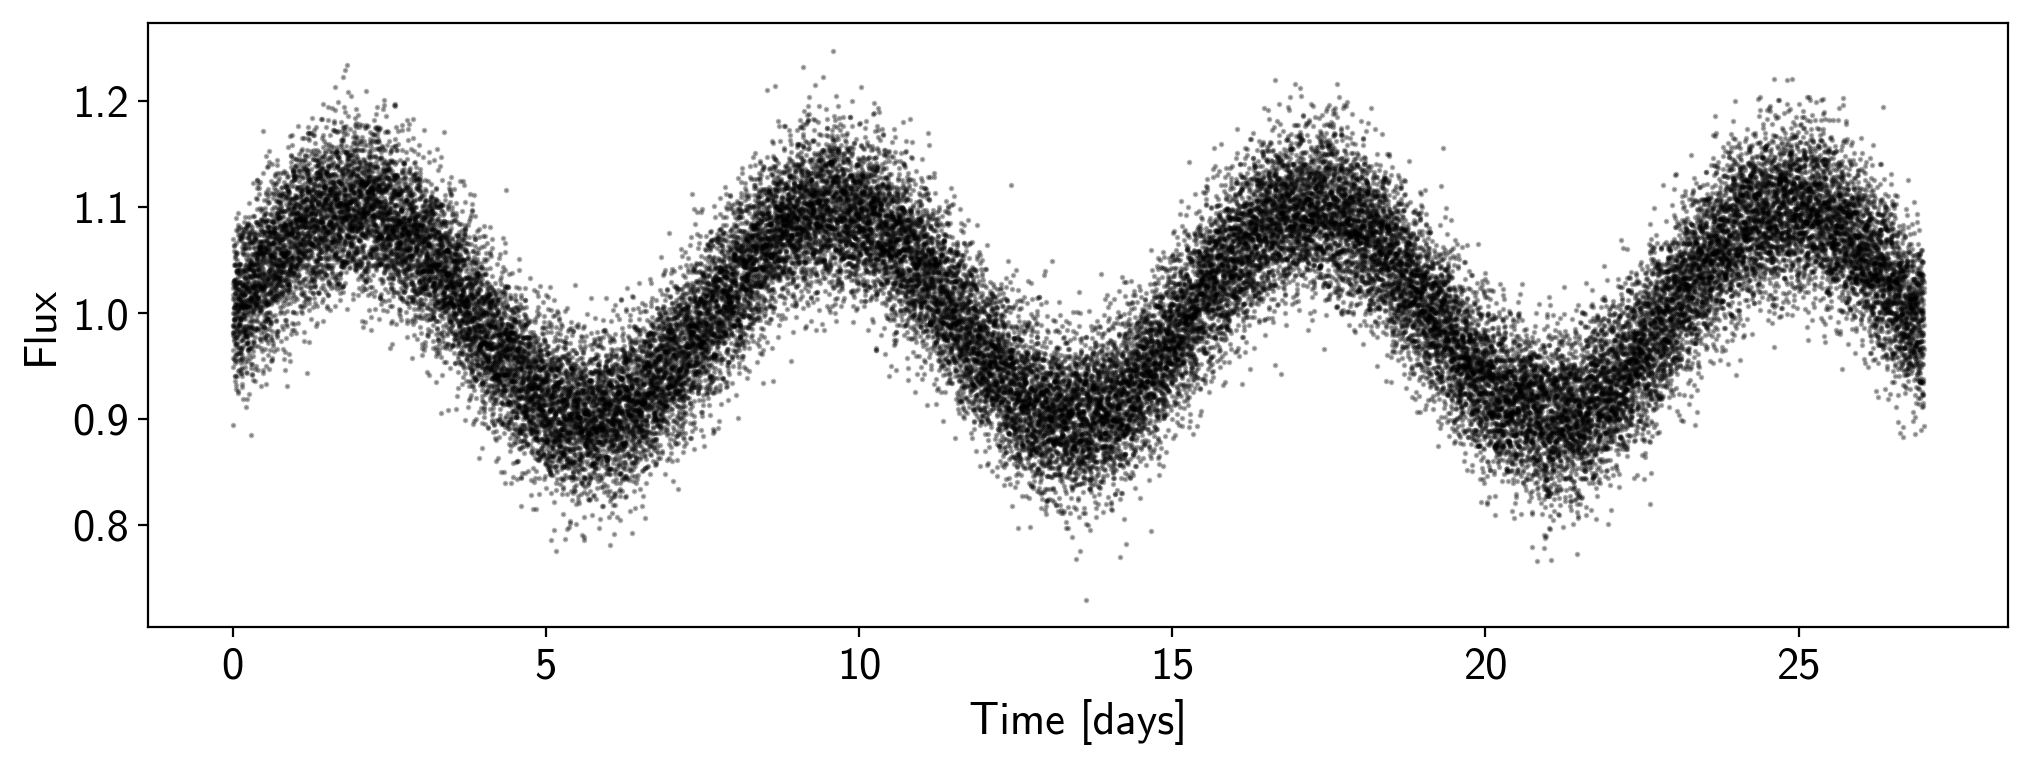

In [7]:
plt.plot(time, flux, 'k.', ms=2, alpha=0.3)
plt.xlabel("Time [days]")
plt.ylabel("Flux");

## 4. Define our model

Write a function that returns the model we are going to fit to the data. In this case, the model $m$ is a function of a single variable, the period $P$, whose value we're going to try to infer.

```python
def model(period):
    return (...)
```

In [8]:
def model(period):
    return 1 + 0.1 * np.sin(2 * np.pi / period * time)

## 5. Grid search for the period

Define an array of ``1,000`` periods over a range that's large enough to include the true period of the dataset. Call this array ``periods``. For each period, compute the model and the chi-squared ($\chi^2$) value of that model. The chi-squared is a metric that describes how good of a fit the model is to the data. In the simplest case, it is just the sum

$
\chi^2 = \sum_t (m_t - f_t)^2
$

where $m_t$ is the value of the model at time $t$, $f_t$ is the value of the flux, and the sum is taken over the entire timeseries. *The smaller the value of $\chi^2$, the better the fit to the data.*

Store the array of $\chi^2$ values in the variable ``chisq``.

For reference later on, time the execution of the cell by prepending

```python
%%time
```

to the top of the cell. (You'll see a summary of how long the cell execution took once it's done.)

In [9]:
%%time
periods = np.linspace(5, 10, 1000)
chisq = np.empty_like(periods)
for i, period in enumerate(periods):
    chisq[i] = np.sum((model(period) - flux) ** 2)

CPU times: user 960 ms, sys: 4.3 ms, total: 964 ms
Wall time: 164 ms


## 6. Plot $\chi^2$

Plot chi-squared versus period, and locate the minimum of the curve. What period does this correspond to?

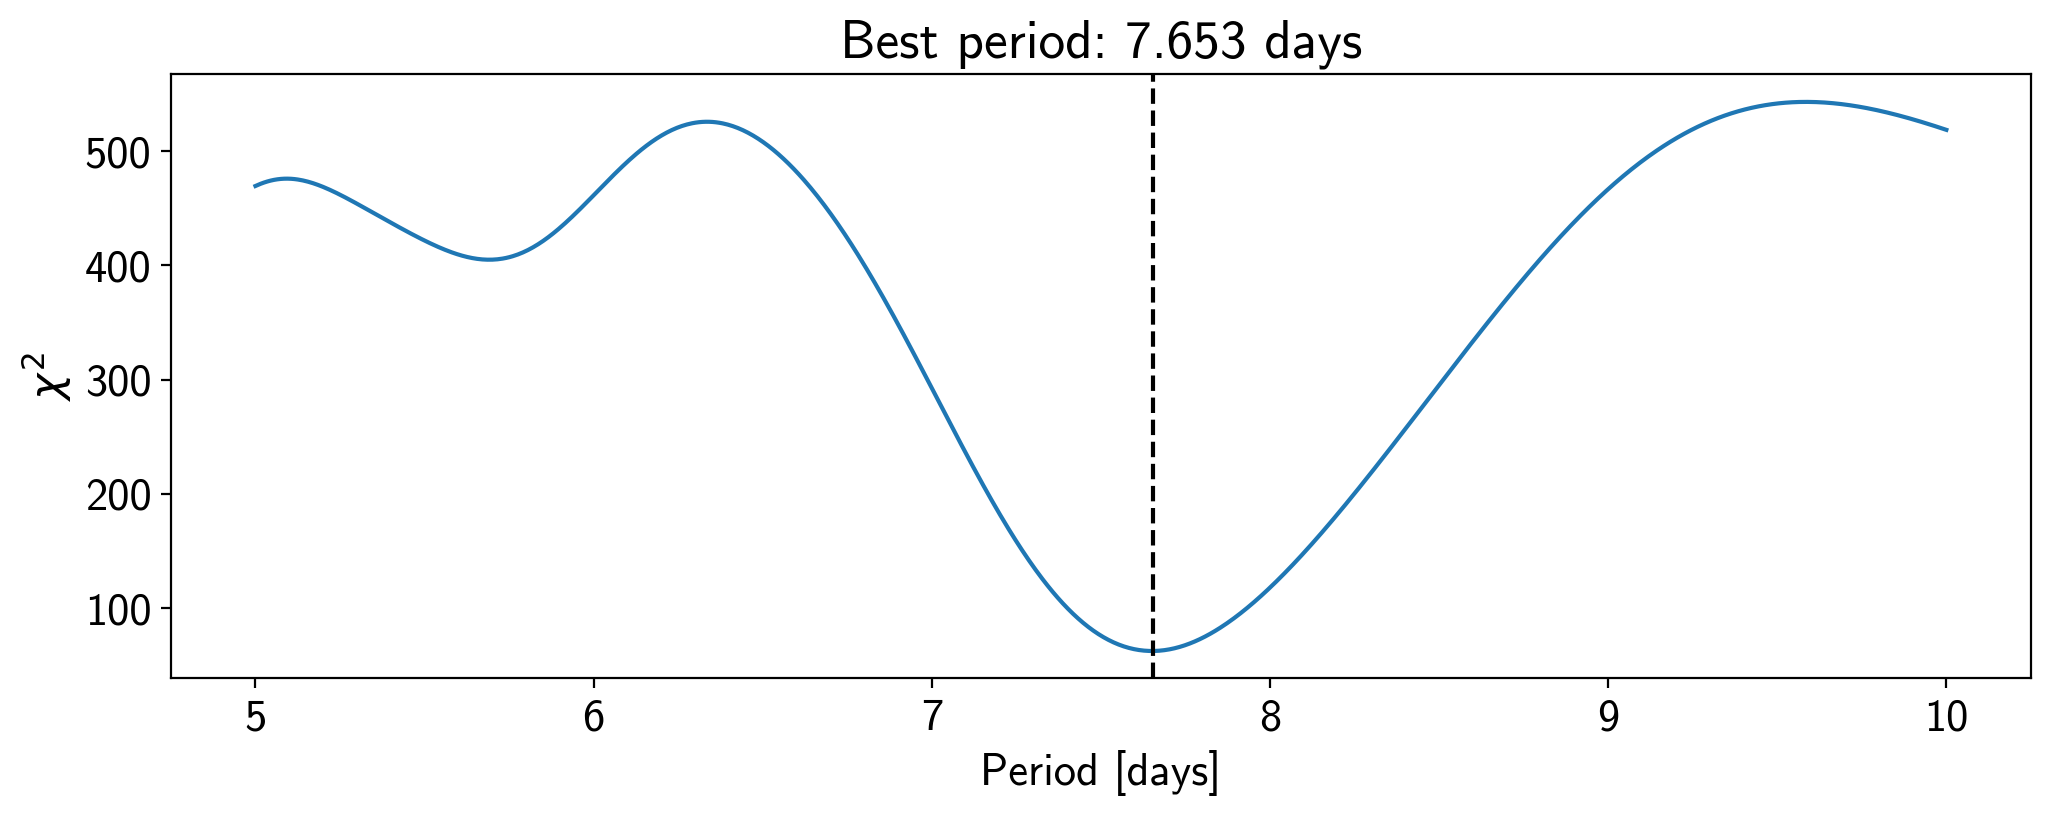

In [10]:
plt.plot(periods, chisq)
best_period = periods[np.argmin(chisq)]
plt.axvline(best_period, color="k", ls="--")
plt.title("Best period: {:.3f} days".format(best_period))
plt.xlabel("Period [days]")
plt.ylabel(r"$\chi^2$");

## 7. Plot the likelihood

We're not done yet, since we need to quantify how certain we are of this value. In reality, we will *never* know the true value of the star's period because our measurements are noisy and our models are always *approximations* of what's actually going on. What we can do, instead, is to figure out some reasonable bounds on the true answer. We will do this by computing the *likelihood* $\mathcal{L}$, which in this case is just

$
\mathcal{L} = \mathrm{e}^{-\frac{1}{2}\chi^2}
$

Store the array of likelihoods in the variable ``likelihood`` and plot the likelihood as a function of period. If all went well, the likelihood should look like a [Gaussian](https://www.mathsisfun.com/data/standard-normal-distribution.html).

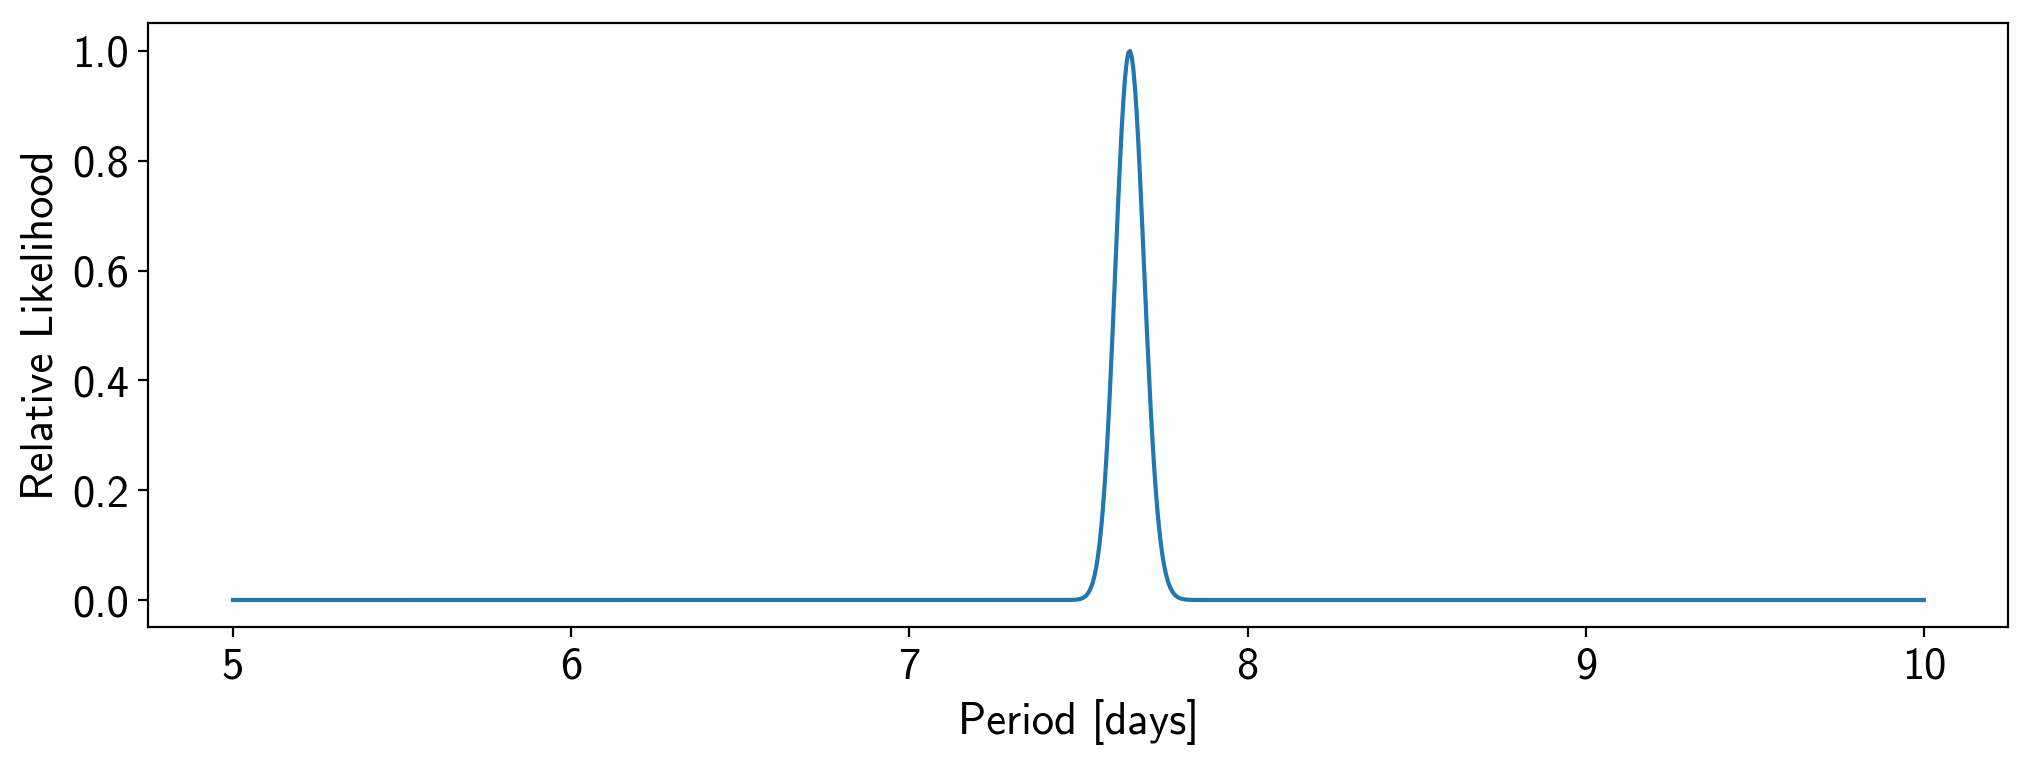

In [11]:
likelihood = np.exp(-0.5 * (chisq - chisq.min()))
plt.plot(periods, likelihood)
plt.xlabel("Period [days]")
plt.ylabel(r"Relative Likelihood");

## 8. Fit a Gaussian
Let's fit an actual Gaussian to our likelihood. In its simplest form, a Gaussian is described by the function

$
f(x; \mu, \sigma) = \mathrm{e}^{-\frac{(x - \mu)^2}{2\sigma^2}}
$

where $x$ is the quantity of interest (in this case, the period), $\mu$ is the *mean* of the Gaussian (the central value, with the highest likelihood), and $\sigma$ is the *standard deviation* of the Gaussian, which is a measure of how wide it is and is therefore equivalent to the uncertainty on the value of the variable.

Define a Gaussian in Python as follows:

```python
def Gaussian(x, mu, sigma):
    return (...)
```

Next, use the ``curve_fit`` function (which we imported at the top; docs [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)) to find the values of $\mu$ and $\sigma$ that best describe the Gaussian-like likelihood we plotted above. We'll do this as follows:

```python
coeff, _ = curve_fit(Gaussian, periods, likelihood, p0=p0)
mu, sigma = coeff
```

where ``p0 = [mu0, sigma0]`` is an array corresponding to initial guesses for ``mu`` and ``sigma``. Find some reasonable values for these and run the code to compute our estimates of ``mu`` and ``sigma``.

Report your inferred period in the form $P = \mu \pm \sigma$.

In [12]:
def Gaussian(x, mu, sigma):
    return np.exp(-(x - mu) ** 2 / (2. * sigma ** 2))

coeff, _ = curve_fit(Gaussian, periods, likelihood, p0=[7.65, 0.1])
mu, sigma = coeff

## 9. Plot the fit
Let's plot our model of the Gaussian over top of the likelihood we computed above, and verify that we obtained a good fit.

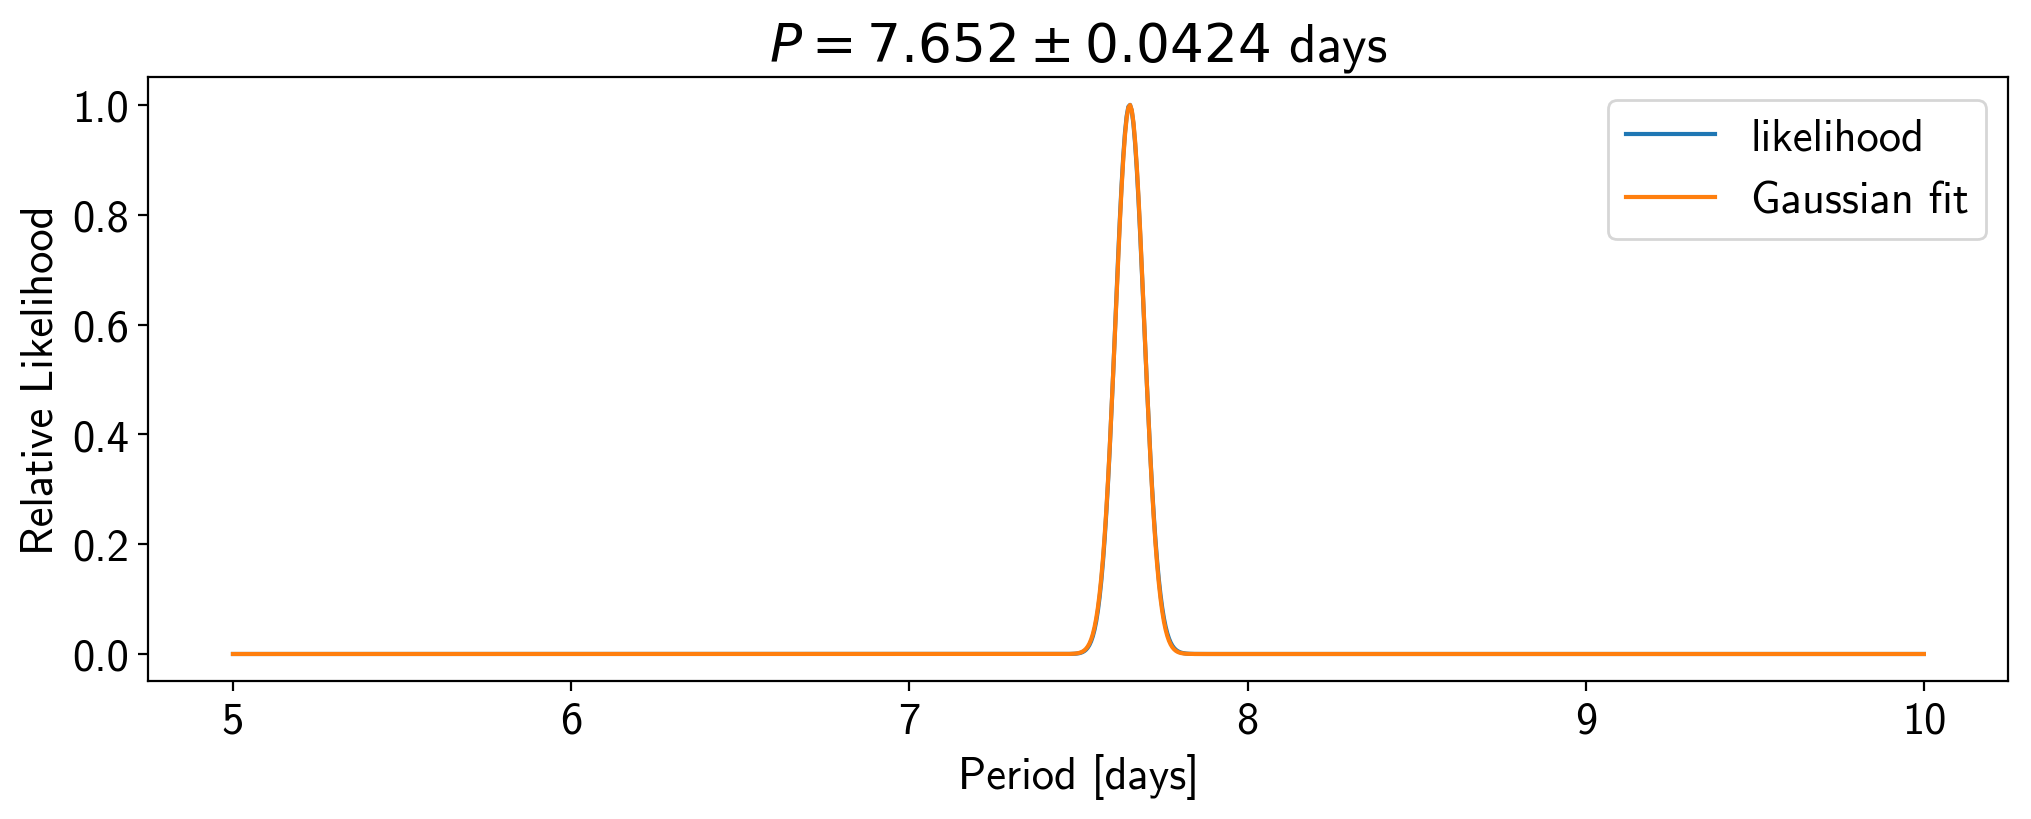

In [13]:
plt.plot(periods, likelihood, label="likelihood")
plt.plot(periods, Gaussian(periods, mu, sigma), label="Gaussian fit")
plt.legend()
plt.xlabel("Period [days]")
plt.ylabel(r"Relative Likelihood");
plt.title("$P = {:.3f} \pm {:.4f}$ days".format(mu, sigma));

## 10. Plot our best model w/ uncertainties
Finally, let's compute the model we defined above using the value of the period we obtained, and overplot it on the data. Is it a good fit? Use ``plt.fill_between`` to fill between the models computed for $\mu - \sigma$ and $\mu + \sigma$, which indicate our credible interval for the true value of the period.

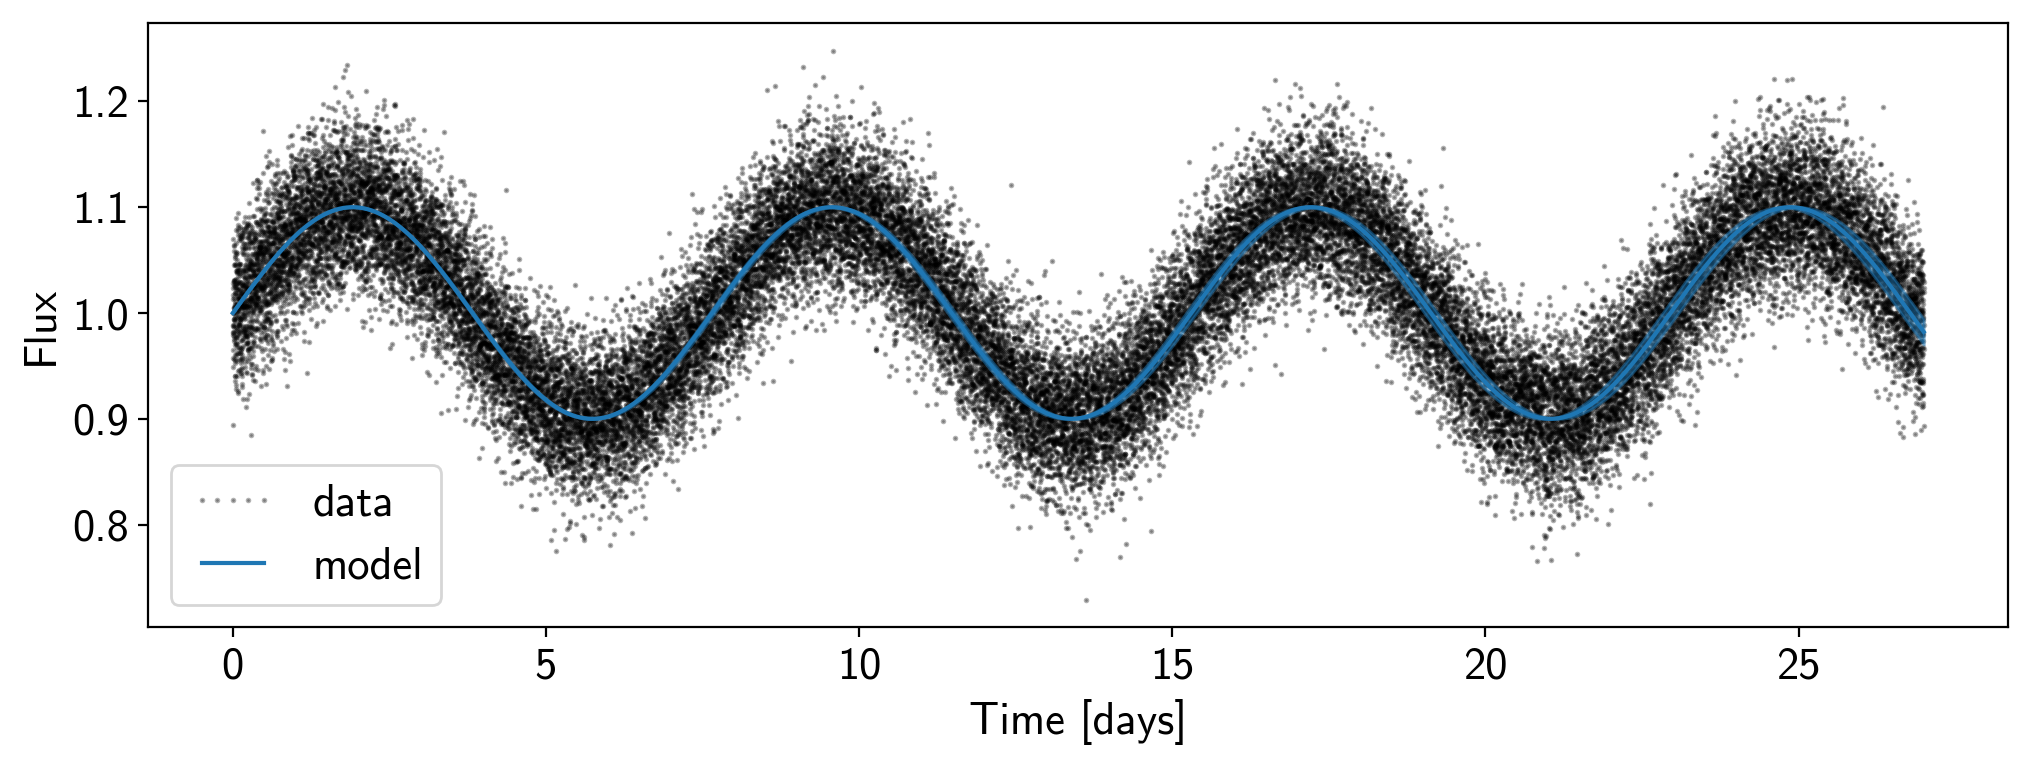

In [14]:
plt.plot(time, flux, 'k.', ms=2, alpha=0.3, label="data", zorder=-1)
plt.plot(time, model(mu), label="model")
plt.fill_between(time, model(mu - sigma), model(mu + sigma), color="C0", alpha=0.5)
plt.xlabel("Time [days]")
plt.legend(numpoints=5)
plt.ylabel("Flux");